# Red neuronal multicapa en PyTorch (solución)

En este notebook veremos como implementar una red neuronal usando PyTorch. En particular, implementaremos un perceptrón multicapa (MLP por sus siglas en inglés) para la classificación de dígitos del conjunto de datos MNIST.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/irvingvasquez/practicas_pytorch/blob/master/soluciones/02_red_neuronal.ipynb)

@juan1rving

In [2]:
# Primero llamamos a los paquetes necesarios
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import matplotlib.pyplot as plt

import numpy as np
import torch
from torchvision import datasets, transforms

## Conjunto de datos

Para la práctica necesitaremos un conjunto de datos (dataset). Afortunadamente el paquete **torchvision** provee diversos conjuntos de datos de ejemplo. En este ejercicio, utilizaremos MNIST, el cual contiene ejemplos de letras escritas a mano. El siguiente código lee el conjunto de datos y lo separa en un conjunto de entrenamiendo y uno de prueba. 

In [6]:
# Generaramos una transformación para normalizar el conjunto de datos
transform = transforms.Compose([transforms.ToTensor(),
                              #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transforms.Normalize([0.5],[0.5]) 
                             ])
# Descargamos el conjunto de datos de entrenamiento
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
# Cargamos el conjunto
batch_size=64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Descargamos y cargamos el conjunto de prueba
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [7]:
# Ordenamos los datos para tener parejas de imágenes con su respectiva clase

# Los datos se encuentran en trainloader asi que generamos un iterador para extraerlos uno por uno
dataiter = iter(trainloader)

# TODO: Obtén un lote de ejemplos y sus respectivas etiquetas
images, labels = next(dataiter)

Es recomendable verificar que estamos cargando bien el conjunto de datos. Asi que a continuación imprimeremos uno.

torch.Size([1, 28, 28])

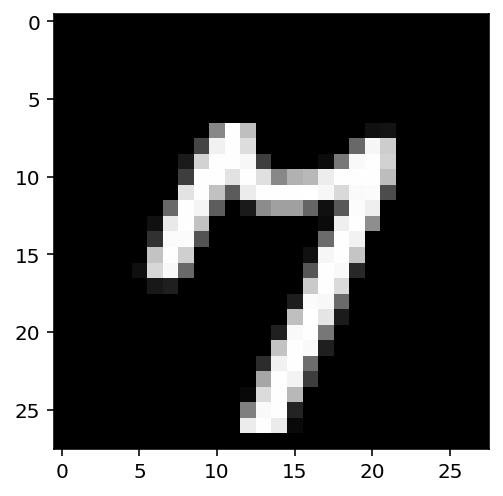

In [8]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');
images[1].size()

## Implementación de la red neuronal multicapa

Ahora pasaremos a la creación de la red neuronal, como ejemplo utilizaremos un perceptrón multicapa para clasificar las imagenes del conjunto MNIST. Como entrada tendremos 784 nodos = 28 * 28, en seguida tendremos una capa oculta de 128 nodos, con una función de activación tipo RELU, despúes tendremos una segunda capa oculta con 64 nodos y función de activación RELU, en seguida tendremos 10 nodos de salida los cuales pasan por una función softmax que convierte los valores a probabilidades. En el siguiente ejercicio incluiremos la pérdida (loss) con la función de entropía cruzada. 

<img src="../archivos/net.png">

El modulo que contiene las herramientas para crear la RN es **pytorch.nn**. La red neuronal en sí se crea como una clase que hereda la estructura de **pytorch.nn.Module**. Cada una de las capas de la red se define de forma independiente. e.g. Para crear una capa con 784 entradas y 128 nodos utilizamos *nn.Linear(784, 128)*

La red implementa la función *forward* que realiza el paso frontal (fowdward pass). Esta función miembro recibe un tensor como entrada y calcula la salida de la red.

Varias funciones de activación se encuntran en el módulo *nn.functional*. Dicho módulo usualmente se importa como *F*. 


In [9]:
# importamos paquetes de pytorch
from torch import nn
import torch.nn.functional as F

En general las redes implementan a partir de la clase nn.Module que provee la clase base. Por lo tanto en este ejercicio declararemos una clase denominada red neuronal que hereda de nn.Module.  Una vez declarada nuestra red neuronal es necesario includir como atributos de la case las capas que se requieren, esto por que cada capa incluye los parámetros (pesos) que se entrenarán y deben tener permanencia mientras exista la red. Dichas capas se incluirán dentro del constructor __init__ . 

De acuerdo a pytorch.org

    nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)

Applies a linear transformation to the incoming data.

Por lo tanto si queremos uncluir una sola capa podríamos codificar lo siguiente:

    self.fc = nn.Lnear(n_inputs, n_outputs)

A continuación definiremos el comportamiento de inferencia de la red dentro de la funcion forward. En el comportamiento indicaremos el orden en el que se van ejecutando las capas y las funciones de activación. Recuerda que las funciones de activación solo se llaman pero no se instancían. Un ejemplo de una sola capa sería:

    def forward(self, x):
        y = F.relu(self.fc(x))
        return y


In [10]:
# Implementación de la red neuronal
class RedNeuronal(nn.Module):
    def __init__(self):
        super().__init__()
        # Definir las capas. Cada una con 128, 64 y 10 unidades respectivamente
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Capa de salida con 10 units (una para cada dígito)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Pase frontal de la red, regresamos las probabilidades '''
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        y = F.softmax(x, dim=1)
        
        return y

In [11]:
model = RedNeuronal()
print(model)

RedNeuronal(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


### Inicializamos pesos y sesgos

Cuando creas las capas se crean también los tensores correspondientes a los pesos y sesgos. Éstos son inicializados por ti, aunque pudes modificarlos usando funciones extra. Para observar sus valores puedes llamar a *model.fc1.weight* 


In [16]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 9.9723e-03, -7.5474e-06,  1.3265e-02,  ...,  2.8805e-02,
         -1.3914e-02, -2.6288e-02],
        [-1.4172e-02,  3.2646e-02,  2.6562e-02,  ...,  2.5904e-02,
         -2.0148e-02, -2.6238e-02],
        [ 1.2665e-03,  3.7877e-03,  3.1762e-02,  ...,  2.7686e-02,
          2.1482e-02, -3.0605e-02],
        ...,
        [ 2.1352e-02,  2.1146e-02, -1.1668e-02,  ..., -1.8667e-02,
         -2.4304e-02,  2.3473e-02],
        [-6.7076e-03,  8.5811e-03, -2.4602e-02,  ...,  1.1613e-02,
          2.4198e-02, -3.2462e-02],
        [-9.6219e-04, -5.3277e-03, -1.5103e-02,  ...,  3.5086e-02,
          2.2136e-02,  3.0636e-02]], requires_grad=True)
Parameter containing:
tensor([ 0.0349,  0.0023, -0.0086,  0.0190,  0.0051,  0.0182, -0.0353, -0.0009,
        -0.0342, -0.0043,  0.0160, -0.0184, -0.0305,  0.0119,  0.0131, -0.0157,
        -0.0218,  0.0288, -0.0278, -0.0194, -0.0157,  0.0270, -0.0241, -0.0325,
        -0.0132, -0.0357, -0.0295,  0.0220, -0.0218,  0.0268, -0

Supongamos que deseamos inicializar los pesos con algunos valores personalizados. Dado que los pesos y sesgos en sí son variables de autograd (Preparadas para el cálculo del gradiente automático) estos solo se pueden modificar cuando no estan en modo de autogradiente.

In [19]:
# Colocamos ceros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
# muestreamos desde una distribución normal con media cero y desv. estandar = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-0.0062,  0.0080,  0.0015,  ...,  0.0103,  0.0073,  0.0207],
        [ 0.0013,  0.0206, -0.0056,  ...,  0.0069, -0.0008,  0.0100],
        [-0.0058,  0.0032,  0.0119,  ..., -0.0003, -0.0244, -0.0037],
        ...,
        [ 0.0064,  0.0067, -0.0066,  ...,  0.0012,  0.0075, -0.0086],
        [ 0.0044,  0.0110, -0.0208,  ...,  0.0008,  0.0018,  0.0105],
        [-0.0169,  0.0023, -0.0010,  ...,  0.0023, -0.0071, -0.0023]])

### Pase frontal

Hasta el momento la red no está entrenada y solo tenemos los pesos aleatorios. Hagamos un pase frontal para ver que pasa. Primero debemos convertir la imagen a un tensor y pasarla a través de la red. 

In [13]:
# Obtengamos el siguiente lote de imágenes
#dataiter = iter(trainloader)
images, labels = dataiter.next()

# Reestructuremos el lote a un vector de una dimensión, hay quien le llama a esta operación "aplanado".
# La nueva forma será (batch size, color channels, image pixels) 
images.resize_(batch_size, 1, 784)
# alternativa: images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Pase frontal de la red
img_idx = 0
prediction = model.forward(images[img_idx,:])

print(prediction)

tensor([[0.0984, 0.1052, 0.0964, 0.1013, 0.0908, 0.0788, 0.1160, 0.1081, 0.1227,
         0.0823]], grad_fn=<SoftmaxBackward0>)


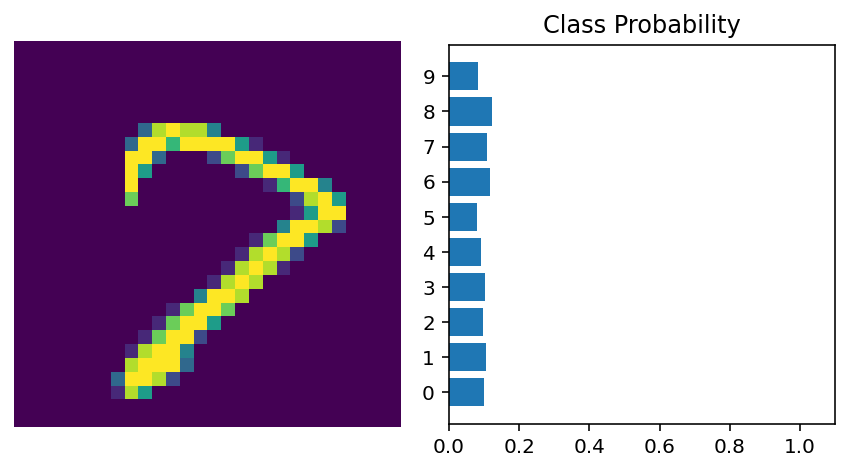

In [15]:
img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), prediction)

Seguro ninguna de las clases tiene una probabilidad grande con respecto de las otras, esto se debe a que todavía no hemos entrenado la red. En el siguiente ejercicio entrenaremos la red.
